# Energy Functions


- This notebook runs tests to see whether the proposed energy functions always decrease with time. 
- It also provides quite a nice place to try out new energy functions derived elsewhere. 
- I have set up a file called `energy_functions.py` to store the functions we might want to try. In the `model_config` object, we can then choose which energy function we want to use.
- This makes it easier to test specific functions within this notebook for instance rather than changing code manually elsewhere

## Energy Functions

- The phenomenological model was derived from the Lagrangian of the JJ-based circuits. This means that the equation of motion theoretically follows the path of least action (which is the integral over the Lagranian with respect to time)


- In SOENs, the energy could perhaps with further work be tied to the underlying physics of the hardware. For instance the energy of a single dendrite is given by:
$$E_i=\frac{1}{2}\beta s_i^2$$ 
but this assumes the linear (large $\tau$) dendritic transfer function


- I have implemented an energy tracking mechanism that computes and keeps track of the energy as the states of the network evolves with time.
- You can toggle this feature on or off to save compute when tracking energy is not necessary
- Depending on the precision needed (or how fast g changes - i.e potentially around the threshold point), you might want to increase of decrease the number of points the `trapz` method uses (not always used in the energy functions but used whenever integration is required)



Equation of motion through configuration space:


$$\frac{ds}{dt} = \gamma g(\phi, s) - \frac{s}{\tau}$$

where:

$s$ is the state variable, 
$t$ is time, 
$\gamma$ is the rate of loop filling, 
$g(\phi, s)$ is the source function, 
$\phi$ is the flux input to the source function, given by $\phi = \sum_j J_{ij}s_j + \phi^{\text{ext}}$, and 
$\tau$ is a time decay constant


Energy functions that are currently under trial in the `energy_functions.py` file:

1. **Local Energy Function (E_SOEN_LOCAL)**:
   $$E_\text{local} = \sum_{i=1}^n \left(-\gamma_i G_i(\phi_i, s_i) + \frac{1}{2\tau_i} s_i^2\right)$$

2. **Global Energy Function (E_SOEN_1)**:
   $$E_\text{global} = -\frac{1}{2} \sum_{i=1}^n \sum_{j=1}^n s_i J_{ij} s_j - \sum_{i=1}^n \gamma_i G_i(\phi_i, s_i) + \frac{1}{2} \sum_{i=1}^n \frac{s_i^2}{\tau_i}$$

3. **Kinetic-Potential Energy Function (E_SOEN_2)**:
   $$E_\text{kinetic-potential} = \sum_{i=1}^n \left(\frac{1}{2} \left(\frac{ds_i}{dt}\right)^2 - \gamma_i G_i(\phi_i, s_i) + \frac{s_i^2}{2\tau_i}\right)$$

4. **Combined Kinetic-Potential and Connection Energy (E_SOEN_3)**:
   $$E_\text{combined} = \sum_{i=1}^n \left(\frac{1}{2} \left(\frac{ds_i}{dt}\right)^2 - \gamma_i G_i(\phi_i, s_i) + \frac{s_i^2}{2\tau_i}\right) + \frac{1}{2} \sum_{i=1}^n \sum_{j=1}^n s_i J_{ij} s_j$$

5. **Global Energy with Kinetic Term (E_SOEN_4)**:
   $$E_\text{global-kinetic} = -\frac{1}{2} \sum_{i=1}^n \sum_{j=1}^n s_i J_{ij} s_j - \sum_{i=1}^n \gamma_i G_i(\phi_i, s_i) + \frac{1}{2} \sum_{i=1}^n \frac{s_i^2}{\tau_i} + \frac{1}{2} \sum_{i=1}^n \left(\frac{ds_i}{dt}\right)^2$$

6. **Sam's Energy Function (E_SAM)**:
   $$E_\text{Sam} = \frac{1}{2} \sum_{i=1}^n \sum_{j=1}^n \tau_i \gamma_i g_i J_{ij} g_j - \sum_{i=1}^n \phi_i^{\text{ext}} g_i$$

7. **Hopfield Energy Function (E_HOPFIELD)**:
   $$E_\text{Hopfield} = \frac{1}{2} \sum_{i=1}^n \phi_i^2 - \frac{1}{2} \sum_{i=1}^n \sum_{j\neq i} g_i J_{ij} g_j - \sum_{i=1}^n (\phi_i^{\text{offset}} + \phi_i^{\text{ext}}) g_i$$

8. **Simple Quadratic Energy Function (E_SIMPLE)**:
   $$E_\text{simple} = \sum_{i=1}^n s_i^2$$


In these equations:
- $s_i$ is the state of node $i$
- $J_{ij}$ is the connection strength between nodes $i$ and $j$
- $\gamma_i$ is the rate of loop filling for node $i$
- $G_i(\phi_i, s_i)$ is the integral of the source function for node $i$
- $\tau_i$ is the time decay constant for node $i$
- $\phi_i$ is the flux input to the source function for node $i$
- $g_i$ is the output of the source function for node $i$
- $\phi_i^{\text{ext}}$ is the external flux input to node $i$
- $\phi_i^{\text{offset}}$ is the flux offset for node $i$


- Note about the kinetic term: I call it this loosely, in the sense that it represents the amount of motion, and therefore is $0$ when $\frac{ds}{dt}=0$ and is always positive.

# 

In [1]:
import sys,os

# go up a dir
os.chdir(os.path.dirname(os.path.abspath("./")))
print(os.getcwd())


from utils.soen_model_utils import *

from model.model_config import *
from model.soen_model import *

import pandas as pd
from tqdm import tqdm

/Users/matthewcox/Documents/UCL/MSc/Full_Phen_SOEN


#### Ignore: Functions to Generate Data and Display it

In [5]:
def plot_energy_diff_histogram(df):
    """
    This function takes in the df that contains the evolutions of energies 
    and then computes the step-wise differences and plots them as a histogram
    """
    # Function to compute energy differences for a single run
    def compute_energy_diff(group):
        return group['mean_energy'].diff()

    # Group by all parameters except time_step to separate individual runs
    grouped = df.groupby(['weight_init_scale', 'initial_state_scale'])

    # Compute energy differences for each run and concatenate them
    all_energy_diffs = pd.concat([compute_energy_diff(group) for _, group in grouped])

    plt.figure(figsize=(10, 6), dpi=300)

    plt.hist(all_energy_diffs, bins=200, density=False, alpha=0.9, color='red', edgecolor='black')

    # plt.yscale('log')
    plt.xlabel('$E_{t+1}-E_{t}$', fontsize=22)
    plt.ylabel('Frequency', fontsize=22)
    

    plt.tick_params(axis='both', which='major', labelsize=16)
    plt.tight_layout()
    plt.xlim(-2,2)
    plt.show()

def run_model_and_get_energy(config, batch_size, initial_state_scale, input_flux_scale):
    # Create a model and chuck it into eval mode. This this means we would use the test_noise_std not the train_noise_std
    model = SOENModel(config).eval()
    # random input scaled by our input_flux_scale
    input_fluxes = (torch.rand(batch_size, config.num_input) * input_flux_scale)
    num_total = config.num_input + config.num_hidden + config.num_output
    # random starting state scaled by initial_state_scale
    initial_states = (torch.rand(batch_size, num_total) * initial_state_scale)
    model(input_fluxes, initial_state=initial_states)
    return model.get_energy_evolution().detach()

def generate_energy_statistics(config, batch_size, weight_init_scales, initial_state_scales, input_flux_scales):
    data = []
    total_iterations = len(weight_init_scales) * len(initial_state_scales) * len(input_flux_scales)
    
    with tqdm(total=total_iterations, desc="Generating Energy Statistics") as pbar:
        for weight_scale in weight_init_scales:
            for state_scale in initial_state_scales:
                for flux_scale in input_flux_scales:
                    config.init_scale = weight_scale  
                    energy_evolution = run_model_and_get_energy(config, batch_size, state_scale, flux_scale)
                    
                    mean_energy = energy_evolution.mean(dim=1).cpu().numpy()
                    std_energy = energy_evolution.std(dim=1).cpu().numpy()
                    
                    for t, (mean, std) in enumerate(zip(mean_energy, std_energy)):
                        data.append({
                            'time_step': t,
                            'weight_init_scale': weight_scale,
                            'initial_state_scale': state_scale,
                            'input_flux_scale': flux_scale,
                            'mean_energy': mean,
                            'std_energy': std
                        })
                    
                    pbar.update(1)
    
    return pd.DataFrame(data)

def save_data_to_csv(df, filename):
    df.to_csv(filename, index=False)
    print(f"Data saved to {filename}")

def plot_energy_statistics_from_df(df):
    plt.figure(figsize=(15, 10), dpi=300)
    
    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams['figure.facecolor'] = 'white'
    plt.rcParams['axes.edgecolor'] = 'black'
    plt.rcParams['axes.linewidth'] = 1.5
    
    weight_scales = sorted(df['weight_init_scale'].unique())
    state_scales = sorted(df['initial_state_scale'].unique())
    flux_scales = sorted(df['input_flux_scale'].unique())
    
    colors = plt.cm.viridis(np.linspace(0, 1, len(weight_scales)))
    linestyles = ['-', '--', ':', '-.']
    
    for i, weight_scale in enumerate(weight_scales):
        for j, flux_scale in enumerate(flux_scales):
            subset = df[(df['weight_init_scale'] == weight_scale) & 
                        (df['input_flux_scale'] == flux_scale)]
            
            for state_scale in state_scales:
                data = subset[subset['initial_state_scale'] == state_scale]
                
                plt.plot(data['time_step'], data['mean_energy'], 
                         color=colors[i],
                         linestyle=linestyles[j % len(linestyles)],
                         linewidth=1.5,
                         alpha=0.7)
                
                plt.fill_between(data['time_step'],
                                 data['mean_energy'] - data['std_energy'],
                                 data['mean_energy'] + data['std_energy'],
                                 alpha=0.1, color=colors[i])
        
  
        plt.plot([], [], color=colors[i], linewidth=2,
                 label=f'Weight Init σ = {weight_scale:.2f}')
    
   
    for j, flux_scale in enumerate(flux_scales):
        plt.plot([], [], color='black', linestyle=linestyles[j % len(linestyles)],
                 label=f'Input Flux σ = {flux_scale:.2f}')

    plt.xlabel('Time Step', fontsize=18)
    plt.ylabel('Energy', fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=14)
    
    plt.legend(fontsize=12, title='Parameters', title_fontsize=14, bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


def compute_energy_change_percentages_stepwise(df, tolerance=1e-6):
    def compute_energy_diff(group):
        return group['mean_energy'].diff()
    
    # Group by all parameters except time_step
    grouped = df.groupby(['weight_init_scale', 'initial_state_scale', 'input_flux_scale'])
    
    all_energy_diffs = pd.concat([compute_energy_diff(group) for _, group in grouped])
    all_energy_diffs = all_energy_diffs.dropna()
    
    total_steps = len(all_energy_diffs)
    
    increases = np.sum(all_energy_diffs > tolerance)
    decreases = np.sum(all_energy_diffs < -tolerance)
    no_changes = np.sum(np.abs(all_energy_diffs) <= tolerance)
    
    results = {
        "Percentage of Increases": (increases / total_steps) * 100,
        "Percentage of Decreases": (decreases / total_steps) * 100,
        "Percentage of No Changes": (no_changes / total_steps) * 100,
        "Total Steps Analysed": total_steps,
        "Tolerance Used": tolerance
    }
    
    return results

def compute_energy_change_percentages_runwise(df, tolerance=1e-6):
    def compute_energy_change(group):
        start_energy = group['mean_energy'].iloc[0]
        end_energy = group['mean_energy'].iloc[-1]
        return end_energy - start_energy
    
    # Group by all parameters except time_step
    grouped = df.groupby(['weight_init_scale', 'initial_state_scale', 'input_flux_scale'])
    
    # Use apply with include_groups=False to avoid the deprecation warning
    energy_changes = grouped.apply(compute_energy_change, include_groups=False)
    
    total_runs = len(energy_changes)
    
    increases = np.sum(energy_changes > tolerance)
    decreases = np.sum(energy_changes < -tolerance)
    no_changes = np.sum(np.abs(energy_changes) <= tolerance)
    
    results = {
        "Percentage of Increases": (increases / total_runs) * 100,
        "Percentage of Decreases": (decreases / total_runs) * 100,
        "Percentage of No Changes": (no_changes / total_runs) * 100,
        "Total Runs Analysed": total_runs,
        "Tolerance Used": tolerance
    }
    
    return results

def format_results_table(stepwise_results, runwise_results, use_latex=False):
    data = [
        ["Metric", "Step-wise", "Run-wise"],
        ["Percentage of Increases", f"{stepwise_results['Percentage of Increases']:.2f}%", f"{runwise_results['Percentage of Increases']:.2f}%"],
        ["Percentage of Decreases", f"{stepwise_results['Percentage of Decreases']:.2f}%", f"{runwise_results['Percentage of Decreases']:.2f}%"],
        ["Percentage of No Changes", f"{stepwise_results['Percentage of No Changes']:.2f}%", f"{runwise_results['Percentage of No Changes']:.2f}%"],
        ["Total Steps/Runs Analysed", f"{stepwise_results['Total Steps Analysed']}", f"{runwise_results['Total Runs Analysed']}"],
        ["Tolerance Used", f"{stepwise_results['Tolerance Used']}", f"{runwise_results['Tolerance Used']}"]
    ]
    
    if use_latex:
        table = "\\begin{tabular}{lrr}\n\\toprule\n"
        table += " & ".join(data[0]) + " \\\\\n\\midrule\n"
        for row in data[1:]:
            table += " & ".join(row) + " \\\\\n"
        table += "\\bottomrule\n\\end{tabular}"
    else:
        table = "| " + " | ".join(data[0]) + " |\n"
        table += "|" + "|".join(["---" for _ in data[0]]) + "|\n"
        for row in data[1:]:
            table += "| " + " | ".join(row) + " |\n"
    
    return table

def print_energy_analysis_results(df, tolerance=1e-6, use_latex=False):
    stepwise_results = compute_energy_change_percentages_stepwise(df, tolerance)
    runwise_results = compute_energy_change_percentages_runwise(df, tolerance)
    
    table = format_results_table(stepwise_results, runwise_results, use_latex)
    print(table)

def display_energy_analysis_table(df, tolerance=1e-6):
    stepwise_results = compute_energy_change_percentages_stepwise(df, tolerance)
    runwise_results = compute_energy_change_percentages_runwise(df, tolerance)
    
    markdown_table = "| Metric | Step-wise | Run-wise |\n"
    markdown_table += "|--------|-----------|----------|\n"
    markdown_table += f"| Percentage of Increases | {stepwise_results['Percentage of Increases']:.2f}% | {runwise_results['Percentage of Increases']:.2f}% |\n"
    markdown_table += f"| Percentage of Decreases | {stepwise_results['Percentage of Decreases']:.2f}% | {runwise_results['Percentage of Decreases']:.2f}% |\n"
    markdown_table += f"| Percentage of No Changes | {stepwise_results['Percentage of No Changes']:.2f}% | {runwise_results['Percentage of No Changes']:.2f}% |\n"
    markdown_table += f"| Total Steps/Runs Analysed | {stepwise_results['Total Steps Analysed']} | {runwise_results['Total Runs Analysed']} |\n"
    markdown_table += f"| Tolerance Used | {stepwise_results['Tolerance Used']} | {runwise_results['Tolerance Used']} |"
    
    display(Markdown(markdown_table))

#### 

In [6]:
from IPython.display import display, Markdown

# Set up the configuration
config = SOENConfig(
    num_input=100,
    num_hidden=0,
    num_output=0,
    is_input_time_varying=False,
    input_type='flux', 
    dt=0.001,
    max_iter=300,
    track_state_evolution=True,
    run_to_equilibrium=False,
    track_energy=True,
    test_noise_std=0.0,
    activation_function='gaussian_mixture',
    enforce_symmetric_weights=False,
    device='cuda',
    weight_init_method = "normal",
    bias_flux_offsets = True,
    energy_function="energy_soen_local",
)

# Set up experiment parameters
batch_size = 3
weight_init_scales = [0.5,1]
initial_state_scales = [0,0.5,1]
input_flux_scales = [0.1,0.5,1]
tolerance = 1e-4





df = generate_energy_statistics(config, batch_size, weight_init_scales, initial_state_scales, input_flux_scales)
display_energy_analysis_table(df,tolerance)


Generating Energy Statistics:   0%|          | 0/18 [00:00<?, ?it/s]

Generating Energy Statistics: 100%|██████████| 18/18 [00:08<00:00,  2.18it/s]


| Metric | Step-wise | Run-wise |
|--------|-----------|----------|
| Percentage of Increases | 0.43% | 0.00% |
| Percentage of Decreases | 99.55% | 100.00% |
| Percentage of No Changes | 0.02% | 0.00% |
| Total Steps/Runs Analysed | 5364 | 18 |
| Tolerance Used | 0.0001 | 0.0001 |

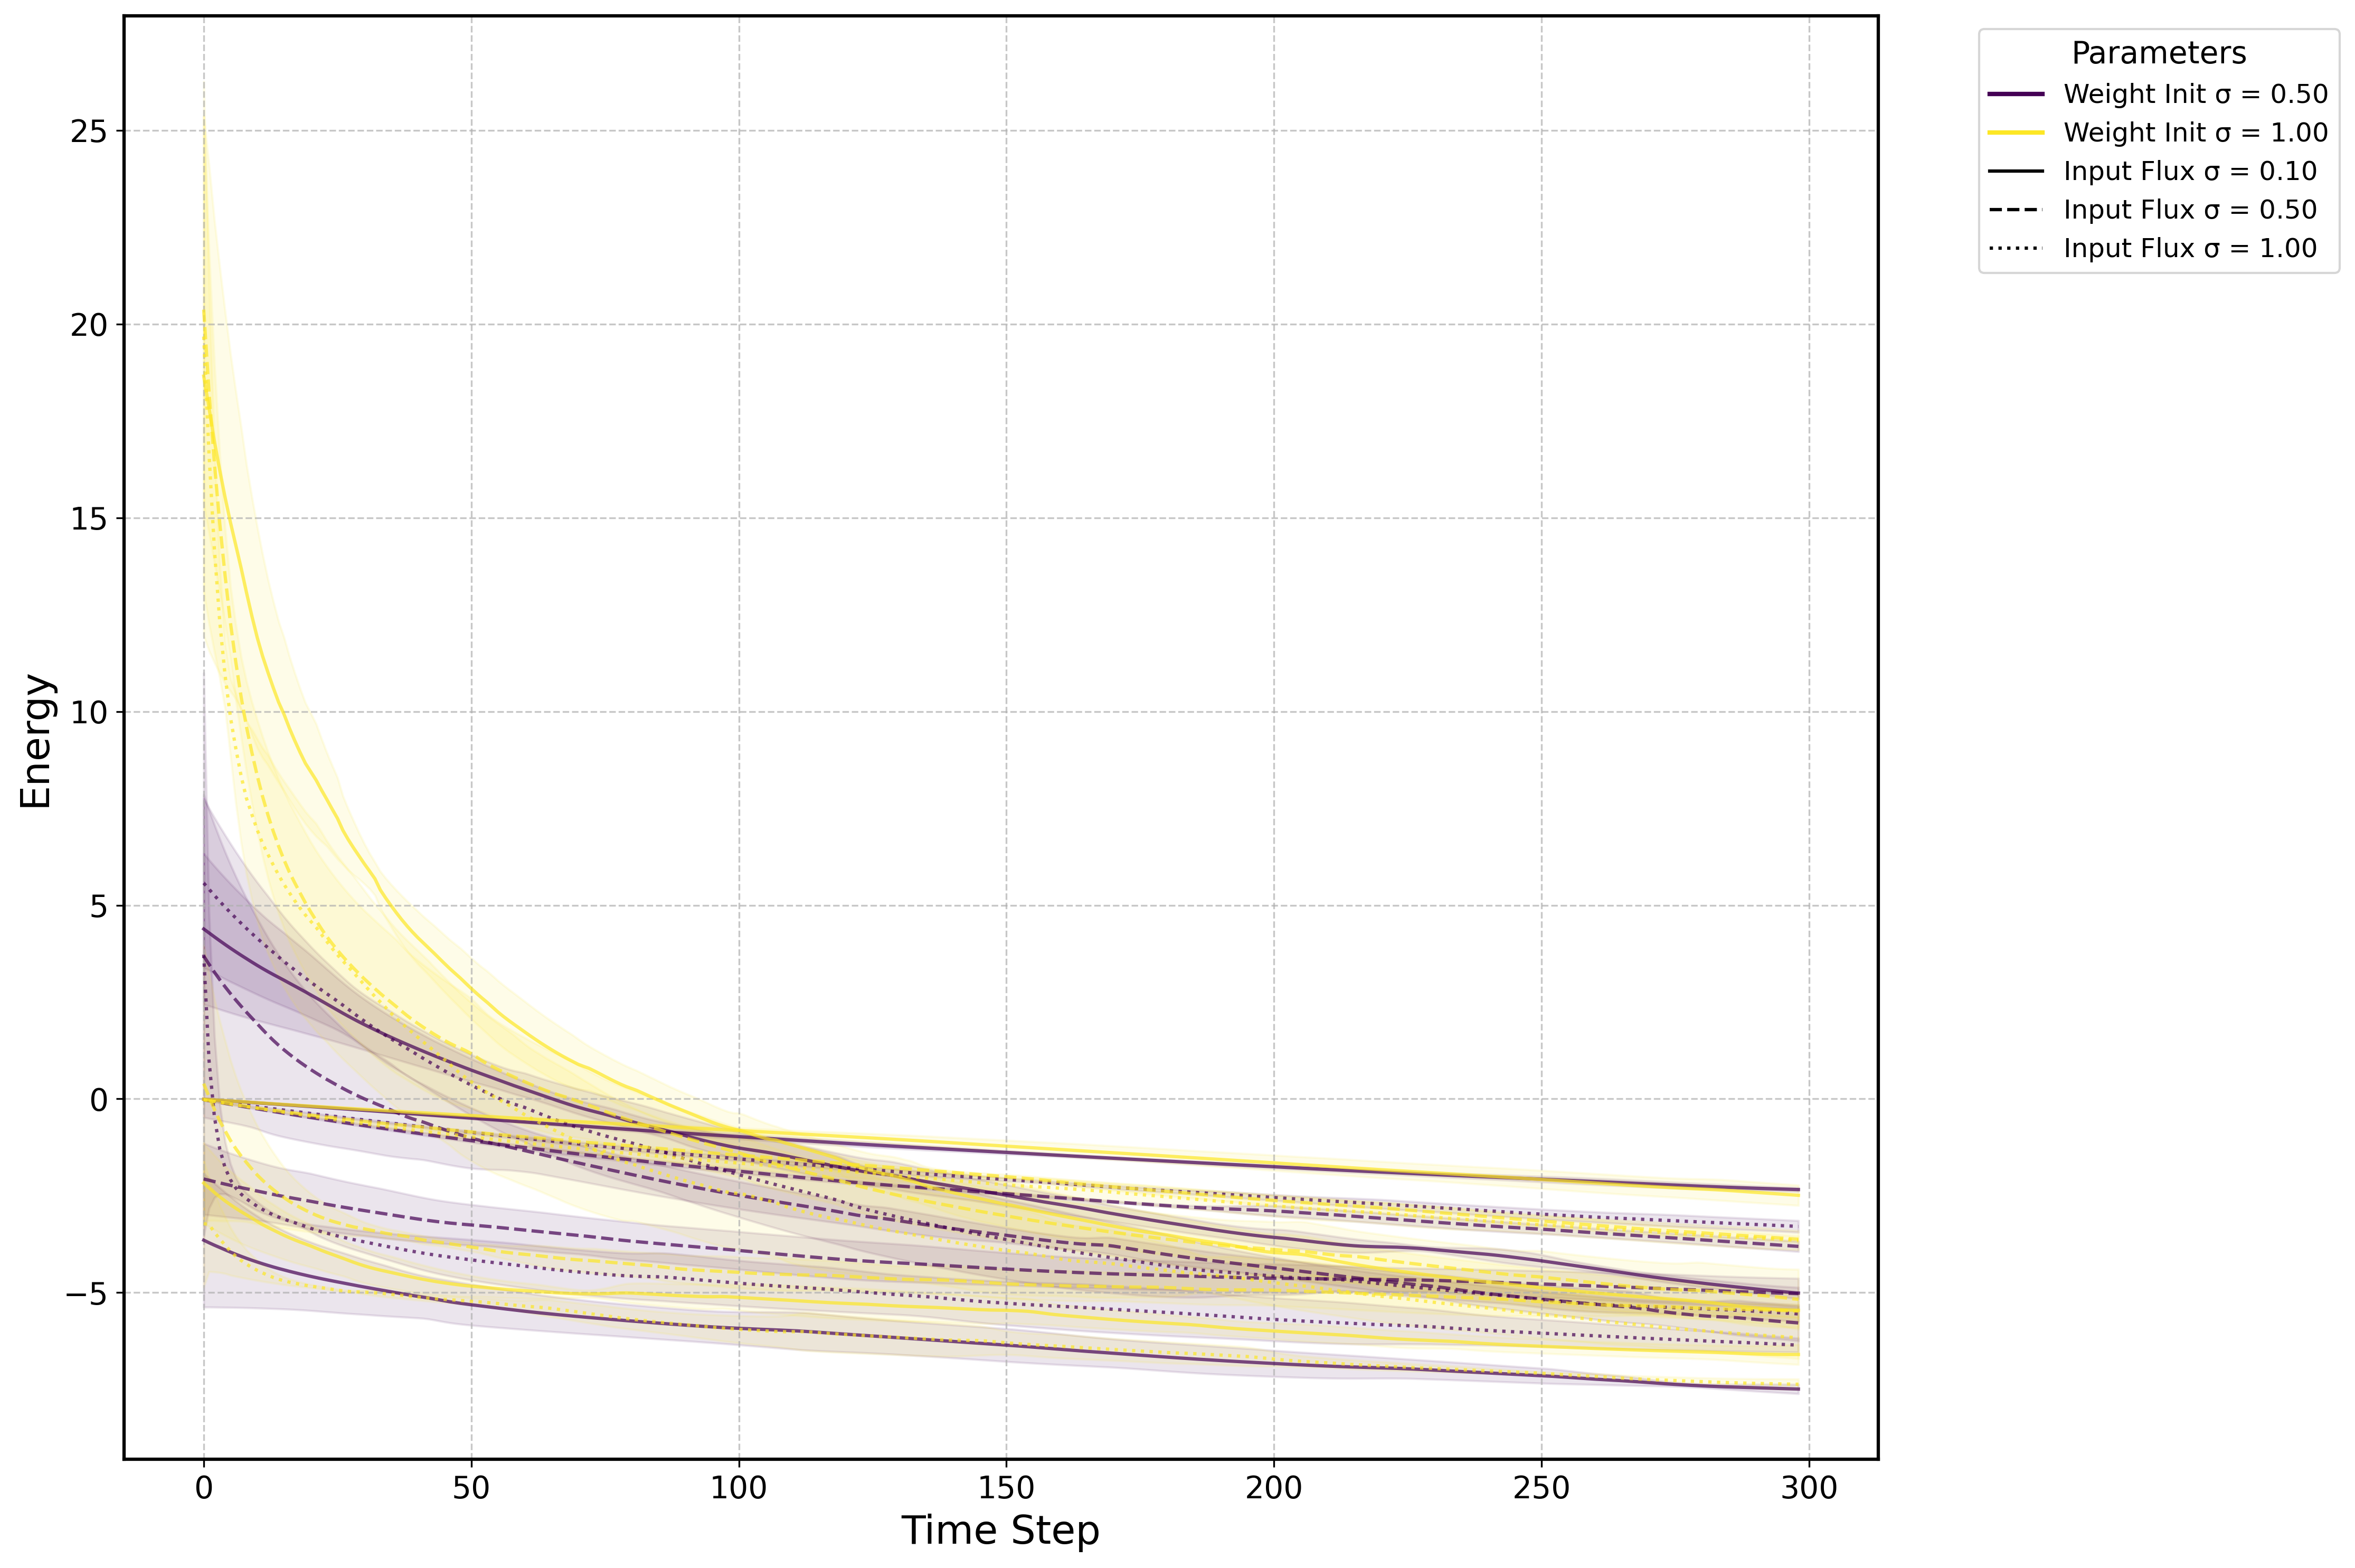

In [4]:
plot_energy_statistics_from_df(df)

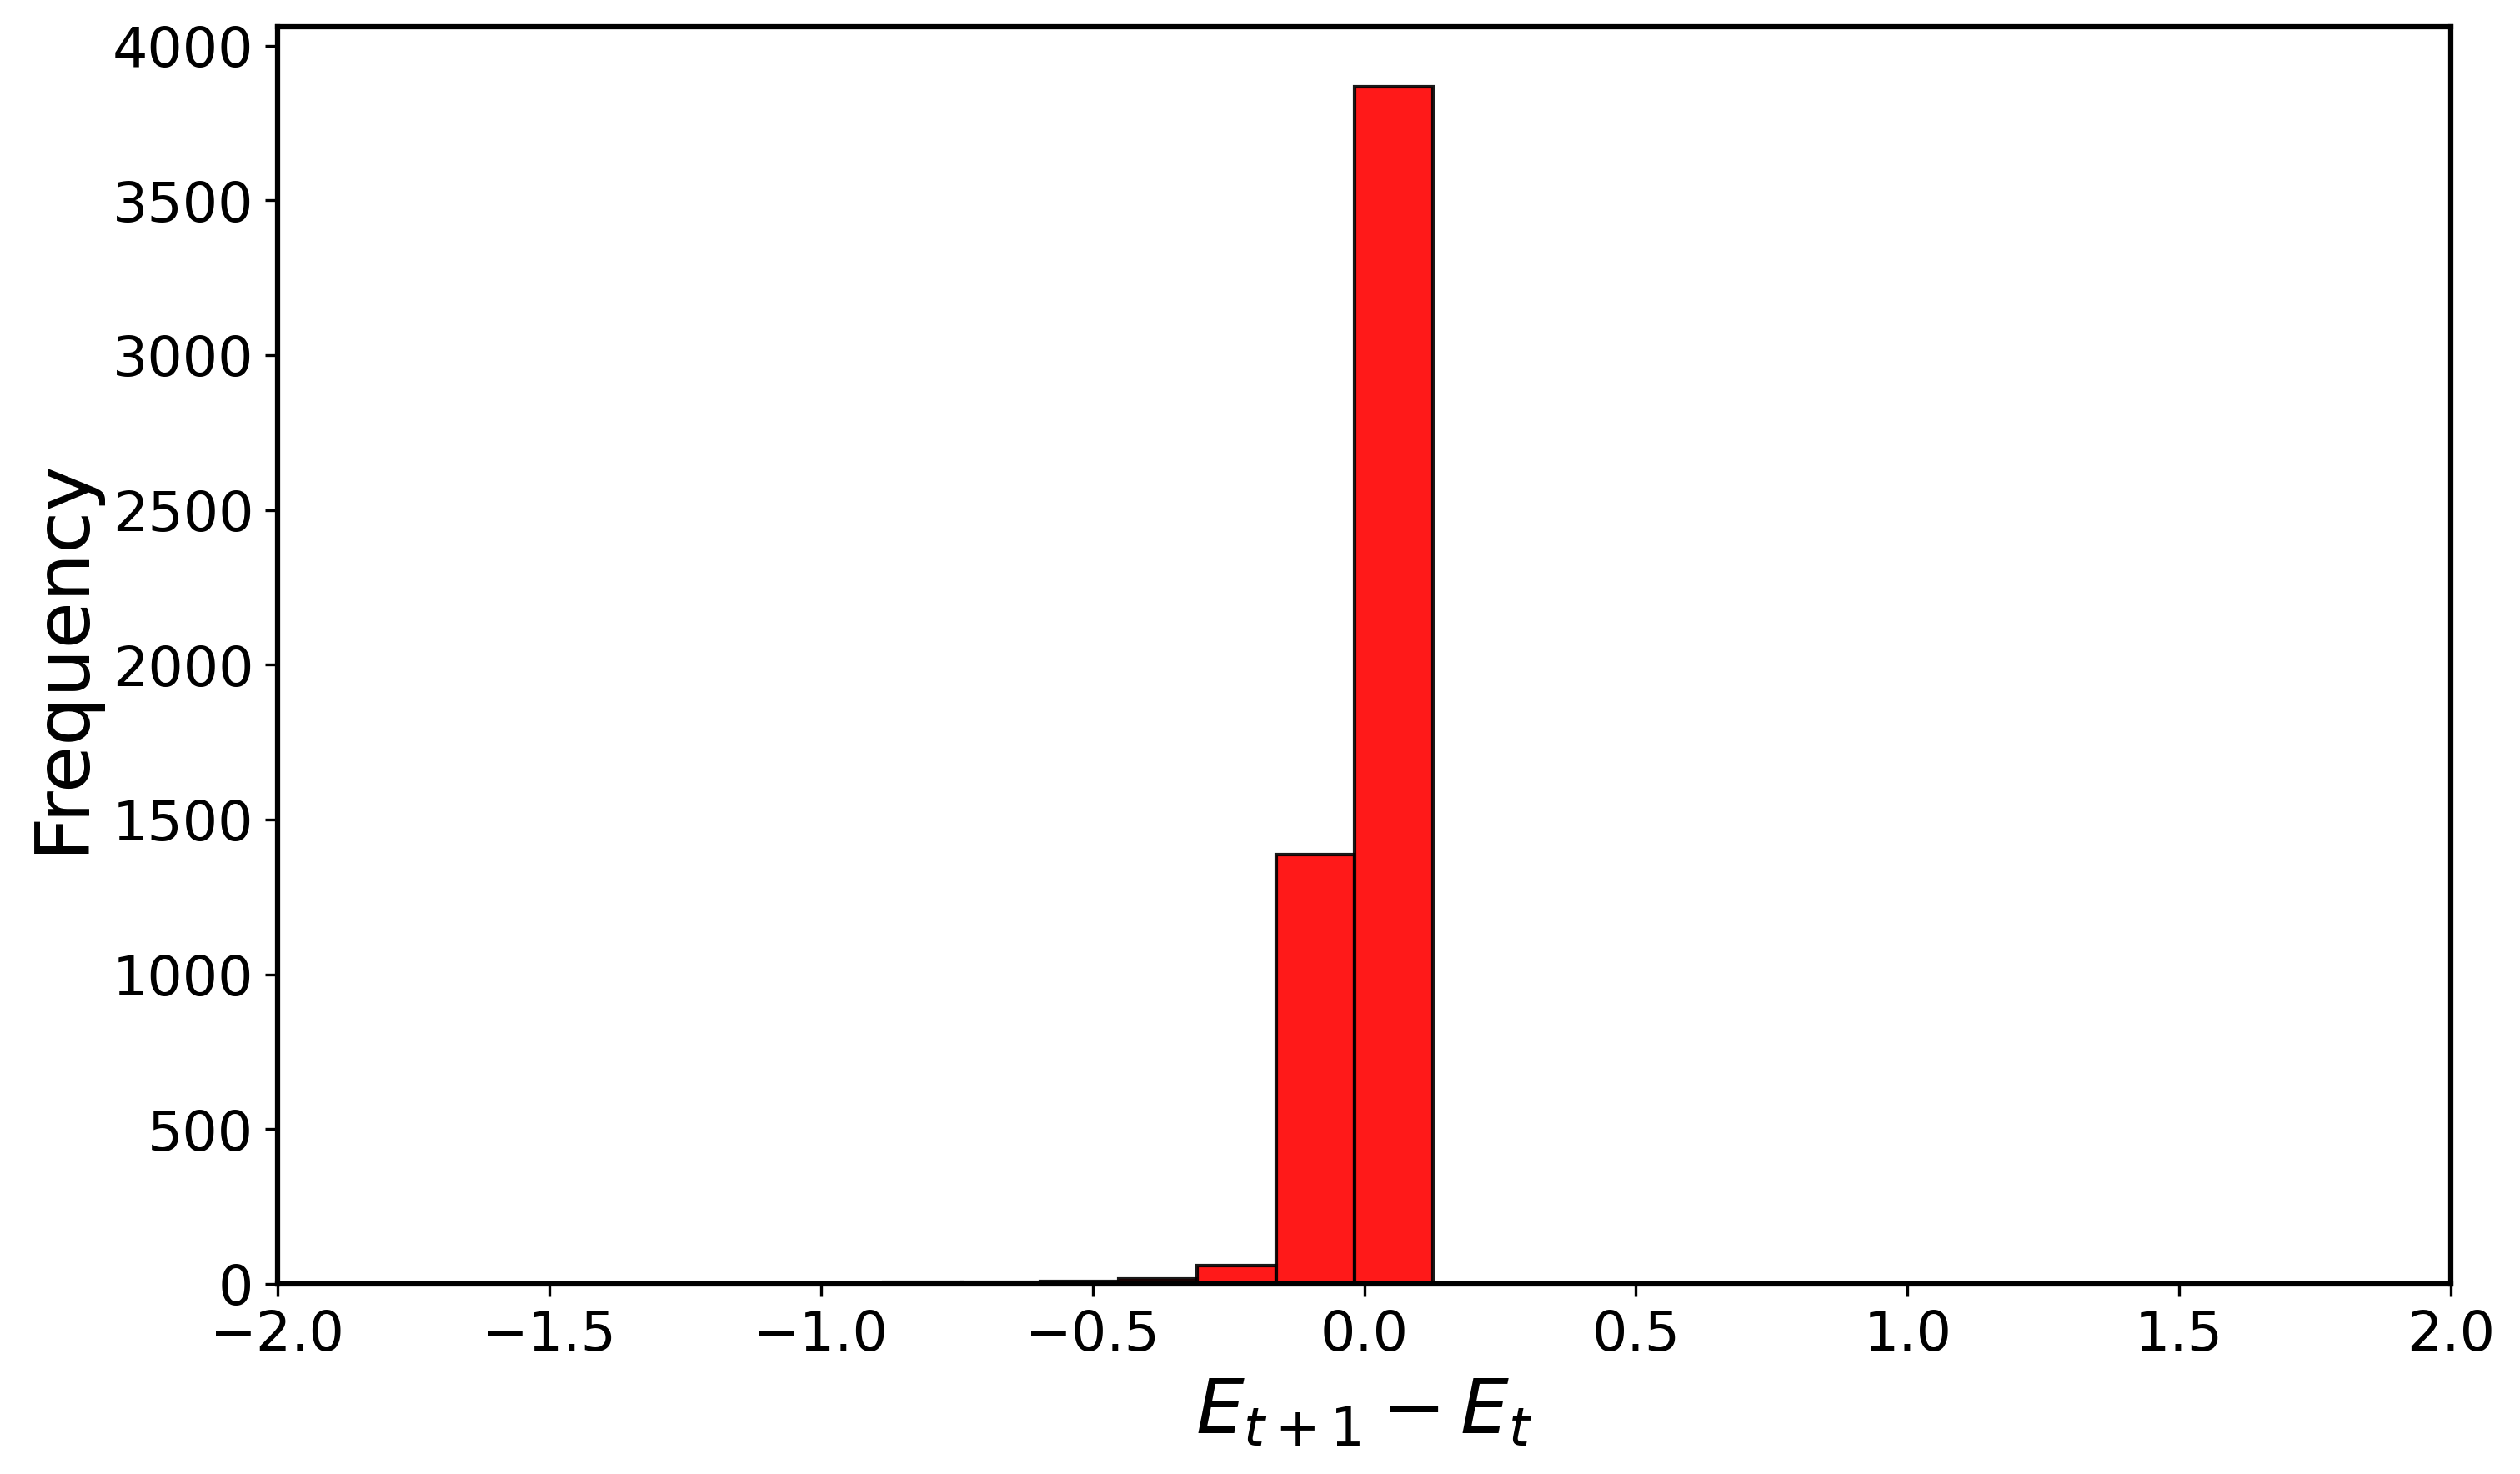

In [5]:

plot_energy_diff_histogram(df)